In [1]:
import os

os.chdir("../../")

import pandas as pd
import numpy as np
from scipy import stats
from scipy import optimize
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [2]:
temperature_data = ingestion.read_temperatures()
ncg_consumption, gaspool_consumption, the_consumption = ingestion.read_consumption()
consumption_data = pd.concat([ncg_consumption + gaspool_consumption, the_consumption])

### Correlation between temperature and natural gas consumption

In [3]:
consumption_data.corr(temperature_data)

-0.9426101754727666

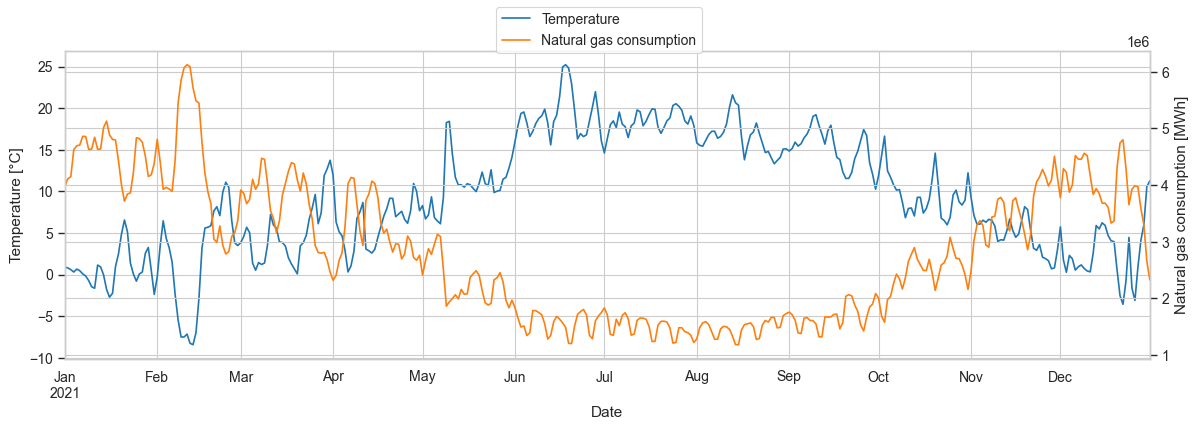

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temperature_data.loc["2021-01-01":"2021-12-31"].plot(ax=ax1, color="tab:blue")
consumption_data.loc["2021-01-01":"2021-12-31"].plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("Temperature [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

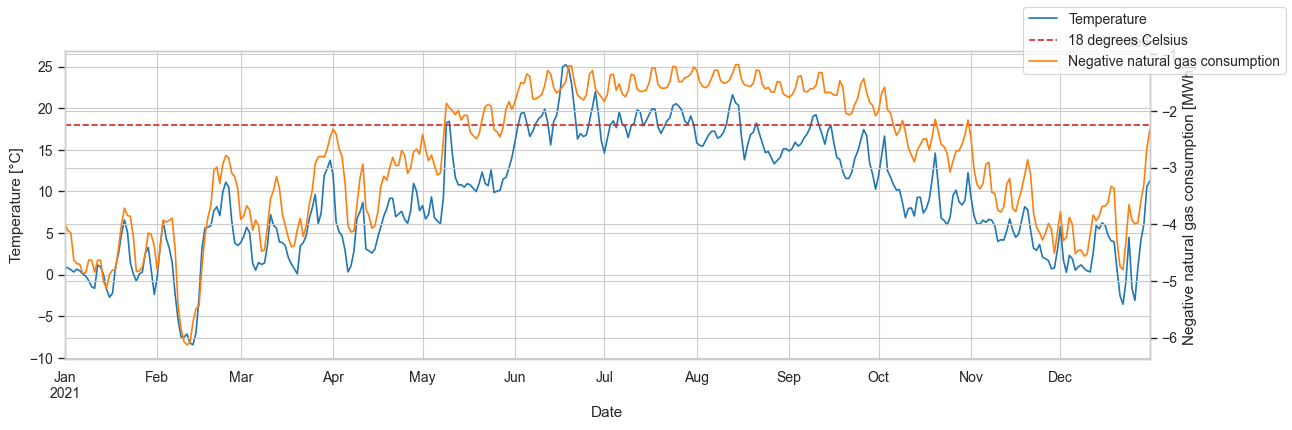

In [5]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temperature_data.loc["2021-01-01":"2021-12-31"].plot(ax=ax1, color="tab:blue")
(consumption_data.loc["2021-01-01":"2021-12-31"] * -1).plot(ax=ax2, color="tab:orange")

# Include horizontal line at 18 degrees celcius
ax1.axhline(18, color="tab:red", linestyle="--")

# Labels and legend
ax1.set_ylabel("Temperature [°C]")
ax2.set_ylabel("Negative natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "18 degrees Celsius", "Negative natural gas consumption"],
    loc="upper right",
)

### Regression analysis

In [6]:
# Intersection of both indices
common_data = consumption_data.dropna().index.intersection(temperature_data.index)

consumption_data_common = consumption_data.loc[common_data]
temperature_data_common = temperature_data.loc[common_data]

Text(0.5, 1.0, 'Temperature vs. natural gas consumption')

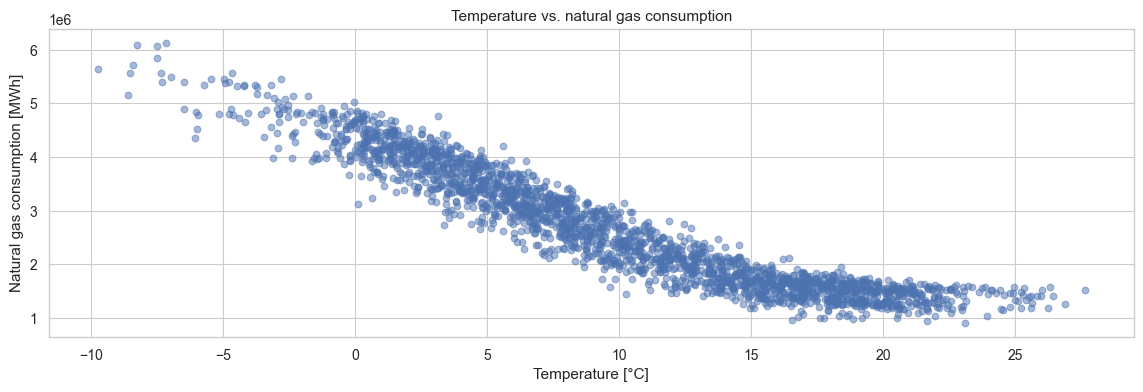

In [7]:
# Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature_data_common, consumption_data_common, alpha=0.5)

# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

Text(0.5, 1.0, 'Temperature vs. natural gas consumption')

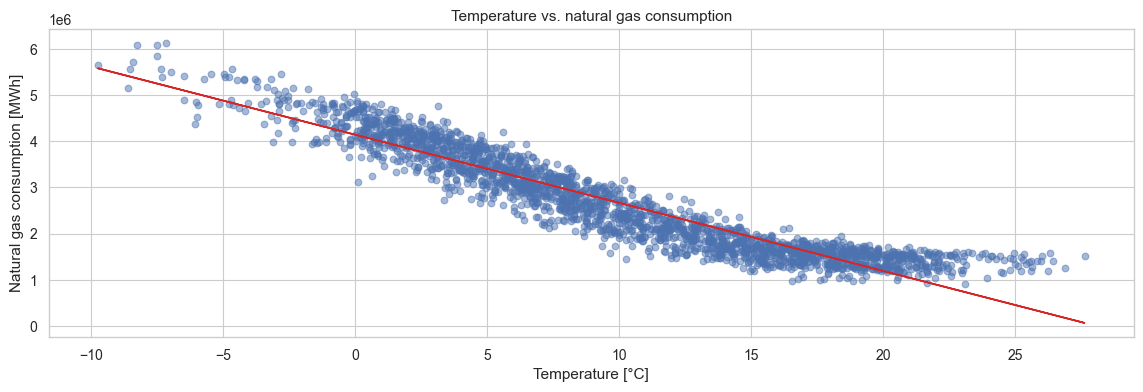

In [8]:
linear_regression = stats.linregress(temperature_data_common, consumption_data_common)

# Plot linear regression
regression_y = linear_regression.slope * temperature_data_common + linear_regression.intercept

# Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature_data_common, consumption_data_common, alpha=0.5)

# Plot linear regression
ax.plot(temperature_data_common, regression_y, color="tab:red")

# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

##### R squared

In [9]:
# Coefficient of determination
linear_regression.rvalue ** 2

0.8885139429048

### Piecewise linear regression

Relationship type 1 for temperatures up to 18 degree Celsius and relationship type 2 for
temperatures above.

d:\anaconda3\envs\ba\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, 'Temperature vs. natural gas consumption')

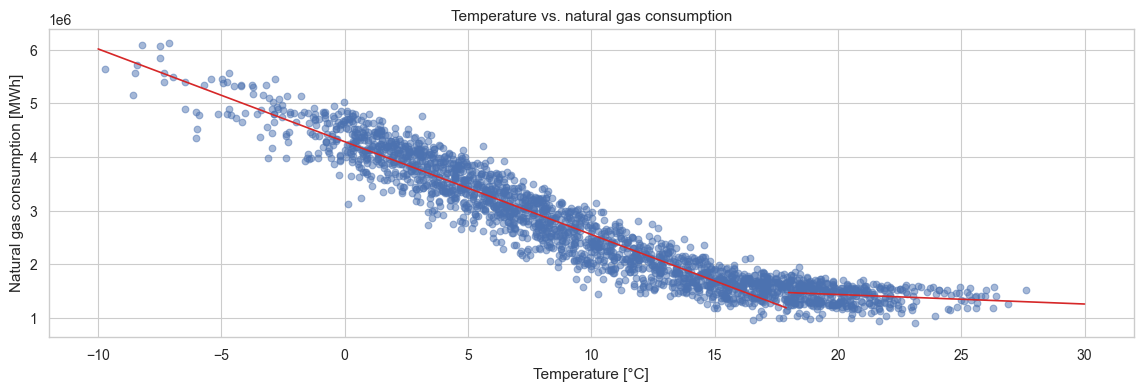

In [10]:
x = temperature_data_common.to_numpy()
y = consumption_data_common.to_numpy()

def piecewise_linear(x, x0, y0, y1, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1 * x + y0, lambda x: k2 * x + y1])

# Fit piecewise linear regression
piecewise_linear_regression, _ = optimize.curve_fit(
    piecewise_linear,
    x,
    y,
    p0=[18, 0, 0, 1, 1],
)

# Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature_data_common, consumption_data_common, alpha=0.5)

# Plot piecewise linear regression by using the fitted parameters
regx = np.linspace(-10, 17.9, 10)
regy = piecewise_linear(regx, *piecewise_linear_regression)
ax.plot(regx, regy, color="tab:red")
regx = np.linspace(18, 30, 10)
regy = piecewise_linear(regx, *piecewise_linear_regression)
ax.plot(regx, regy, color="tab:red")

# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

##### R squared

In [11]:
y_pred = piecewise_linear(x, *piecewise_linear_regression)
metrics.r2_score(y, y_pred)

0.9273141227324878

#### Model vs actual historic natural gas consumption

In [12]:
temp_df = temperature_data.to_frame(name='temp')
temp_df['modelled_gas_consumption'] = piecewise_linear(temp_df['temp'].to_numpy(), *piecewise_linear_regression)

Text(0, 0.5, 'Natural gas consumption [MWh]')

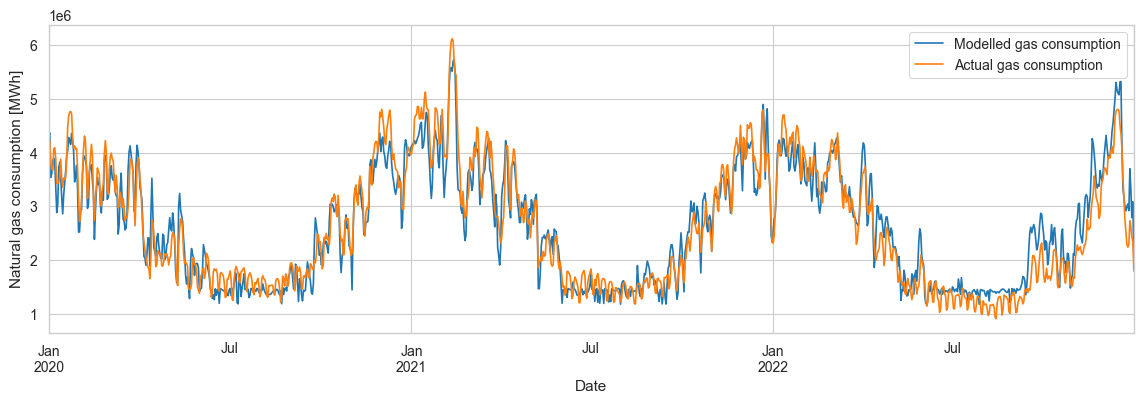

In [13]:
fig, ax = plt.subplots(figsize=(14, 4))
temp_df['modelled_gas_consumption'].loc["2020-01-01":"2022-12-31"].plot(ax=ax, color="tab:blue")
consumption_data.loc["2020-01-01":"2022-12-31"].plot(ax=ax, color="tab:orange")

# Labels and legend
ax.legend(labels=["Modelled gas consumption", "Actual gas consumption"])
ax.set_ylabel("Natural gas consumption [MWh]")

Text(0, 0.5, 'Natural gas consumption [MWh]')

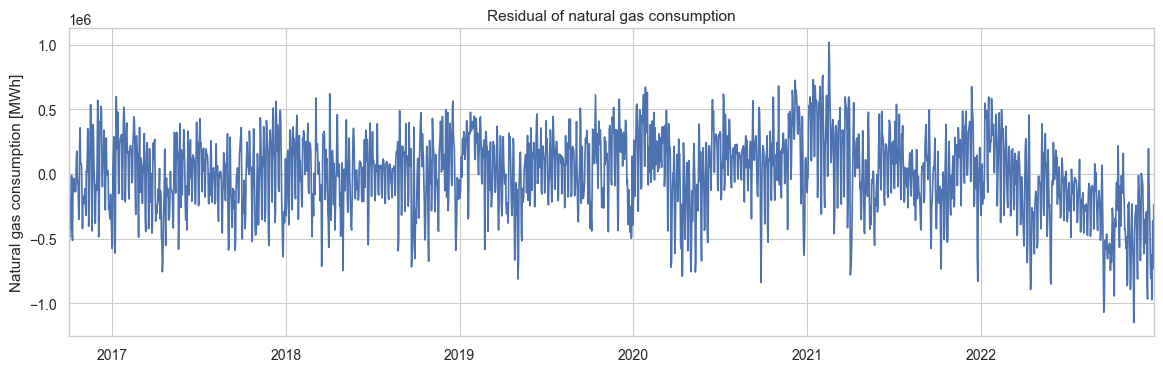

In [14]:
consumption_residual = (consumption_data - temp_df['modelled_gas_consumption']).dropna()

fig, ax = plt.subplots(figsize=(14, 4))
consumption_residual.plot(ax=ax)

ax.set_title("Residual of natural gas consumption")
ax.set_ylabel("Natural gas consumption [MWh]")

Text(0, 0.5, 'Natural gas consumption [MWh]')

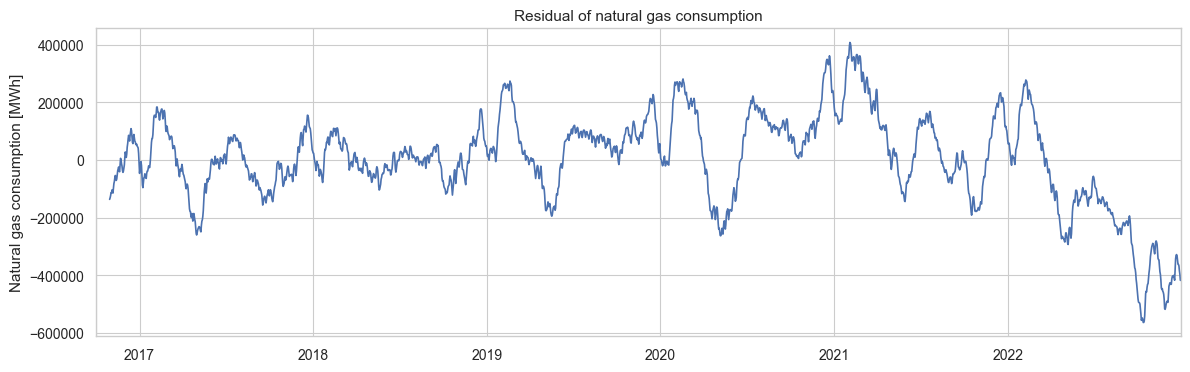

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))

# 30 day rolling mean
consumption_residual.rolling(30).mean().plot(ax=ax)

ax.set_title("Residual of natural gas consumption")
ax.set_ylabel("Natural gas consumption [MWh]")

#### Save model for later reuse

In [16]:
import pickle

# Save model to models/piecewise_linear_temperature_model.pkl
with open("models/piecewise_linear_temperature_model.pkl", "wb") as f:
    pickle.dump(piecewise_linear_regression, f)